In [1]:
from m8r import view

In [2]:
%%file 1_velvel.scons 


Flow('mod',None,
     '''
     spike n1=75 n2=35 d1=0.0533333 d2=0.0242157 o1=0 o2=0.01
     nsp=5 mag=2,1,1,1,1 k1=11,18,33,56,70 k2=28,19,19,19,19
     ''')
Flow('dat','mod','velmod h0=-1 dh=0.141026 nh=40 slowness=y half=n')
Flow('mod2','dat','vscan slowness=y half=n')
Flow('dat2','mod2','velmod slowness=y half=n')

for data in ('mod','dat','mod2','dat2'):
    Plot(data,
         '''
         dots gaineach=0 dots=0 seemean=1 strings=0
         constsep=1 overlap=6. transp=1 label1=" "
         ''')
Result('velvel','mod dat mod2 dat2','TwoRows')

Writing 1_velvel.scons


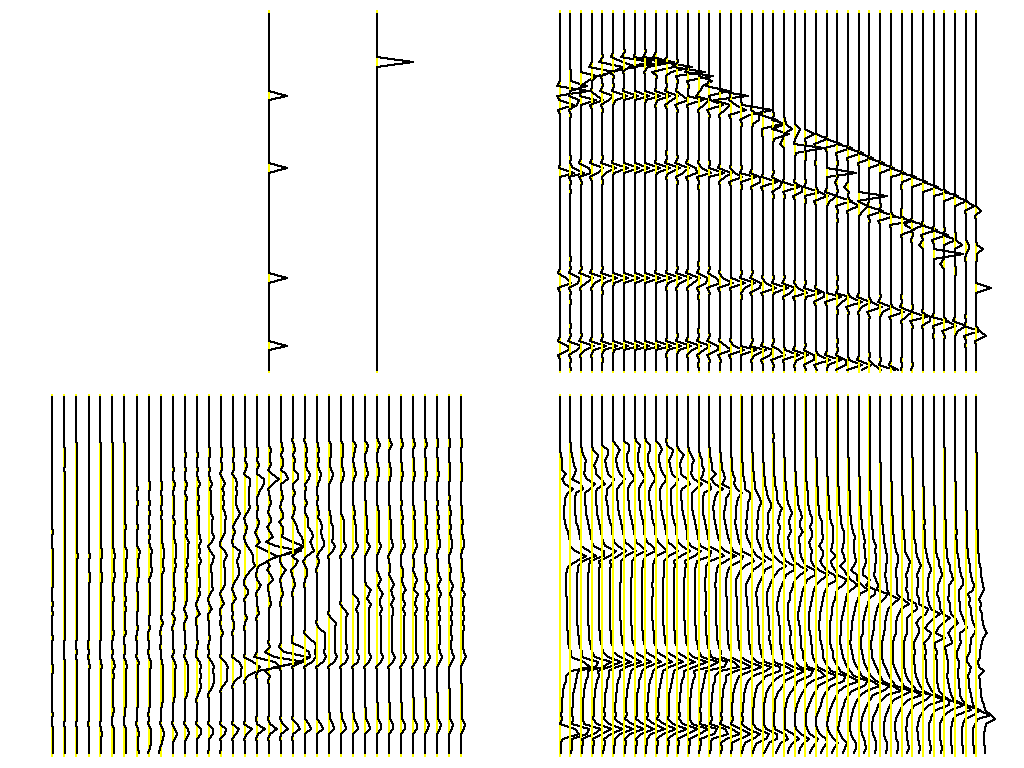

In [3]:
view("velvel")

In [4]:
%%file 2_mutvel.scons 


Fetch('midpts.hh','midpts')

Flow('cdp','midpts.hh','window n3=1 j1=2 | dd form=native')
Flow('mutter','cdp','mutter half=n v0=1.4') 
Flow('veltran','mutter','vscan slowness=y half=n v0=0.3 nv=81 dv=0.005')

sides = ['mutter','veltran']
for case in sides:
    Plot(case,'grey wanttitle=n')
Result('mutvel',sides,'SideBySideAniso',vppen='txscale=1.5')

Writing 2_mutvel.scons


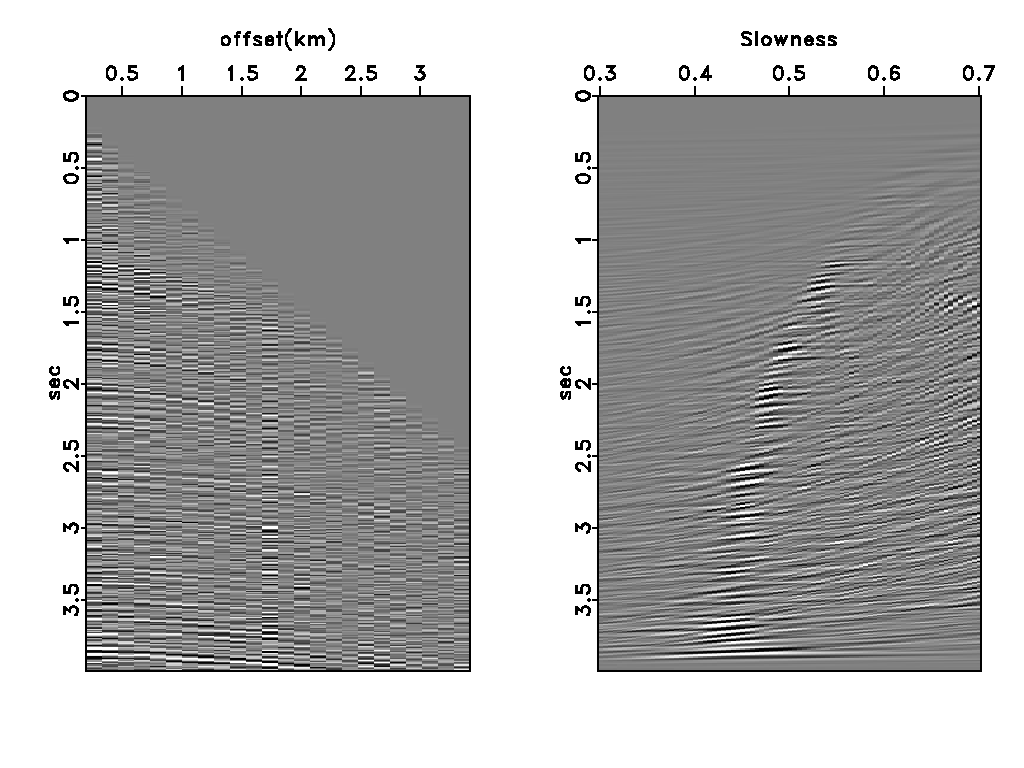

In [5]:
view("mutvel")

In [6]:
%%file 3_fit.scons 


Flow('wgmutter','midpts.hh','dd form=native | mutter half=n v0=1.4')

Flow('wgsmb','wgmutter',
     'vscan slowness=y half=n v0=0.3 nv=81 dv=0.005 semblance=y',split=[3,250])
Flow('wgsmbv','wgmutter',
     'vscan slowness=n half=n v0=%g nv=51 dv=%g semblance=y'%(1.4,0.025),split=[3,250])

Flow('wgfit','wgsmb','pick rect1=17 rect2=17 vel0=0.7')

def graph(col=7,fat=1):
    return '''
    graph min2=0.3 max2=0.7 pad=n transp=y yreverse=y wanttitle=n
    plotcol=%d plotfat=%d wantaxis=n
    ''' % (col,fat)

Flow('fit','wgfit','window n3=1')
Plot('slow',   'fit',graph(1,1))
Plot('fatslow','fit',graph(0,7))
Result('fit','veltran fatslow slow','Overlay')

Writing 3_fit.scons


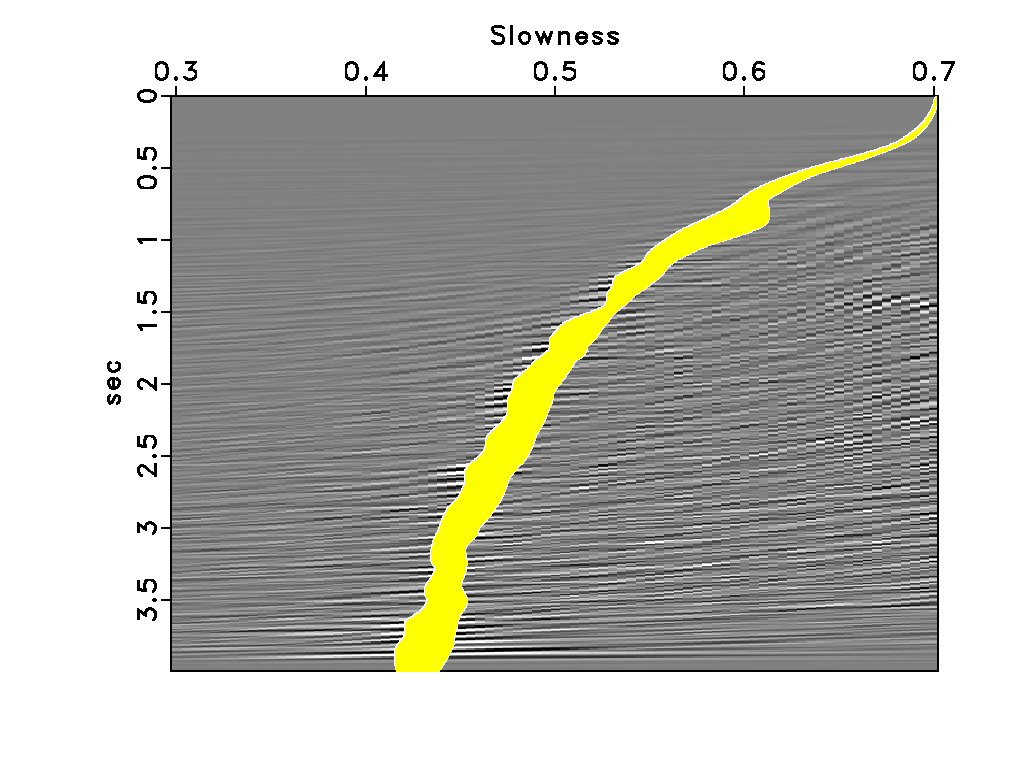

In [7]:
view("fit")

In [8]:
%%file 4_wgstack.scons 


Flow('wgstack',['wgmutter','wgfit'],
     'nmo velocity=${SOURCES[1]} slowness=y half=n | stack')
Result('wgstack','grey title=Stack')

Writing 4_wgstack.scons


In [ ]:
view("wgstack")

In [ ]:
%%file 5_wgpick.scons 


Flow('wgpick','wgstack','shearer short=20 long=200 rect2=5')
Result('wgpick','grey color=j allpos=y title=Picking')

In [ ]:
view("wgpick")

In [ ]:
%%file 6_agcstack.scons 


Flow('agcstack','wgstack','agc')
Result('agcstack','grey title="AGC Stack" ')

In [ ]:
view("agcstack")

In [ ]:
%%file 7_wgvel.scons 


Flow('weight',['wgsmb','wgfit'],'slice pick=${SOURCES[1]}')
Flow('wgrms','wgfit','window | math output=1/input')
Flow(['wgint','wgrms2'],['wgrms','weight'],
     '''
     dix weight=${SOURCES[1]} vrmsout=${TARGETS[1]}
     rect1=10 rect2=10
     ''')

def velplot(title):
    return '''
    grey color=j scalebar=y barlabel="%s (km/s)" allpos=y bias=1.4
    bartype=h wherebarlabel=b wanttitle=n
    ''' % title

Plot('wgrms','wgrms',velplot("RMS velocity"))
Plot('wgint','wgint',velplot("Interval velocity"))
Result('wgvel','wgrms wgint','SideBySideAniso')

In [ ]:
view("wgvel")

In [ ]:
%%file 8_wgvel2.scons 


Plot('wgrms2','wgrms2',velplot("Predicted RMS velocity"))
Result('wgvel2','wgrms wgrms2','SideBySideAniso')

In [ ]:
view("wgvel2")

In [ ]:
%%file 9_wgvel1.scons 


def velgraph(title,max):
    return '''
    window n2=1 |
    graph wanttitle=n transp=y yreverse=y label2="%s (km/s)"
    min2=1.4 max2=%g
    ''' % (title,max)

Plot('rms1','wgrms',velgraph("RMS velocity",2.4))
Plot('rms2','wgrms2',velgraph(" ",2.4) + ' dash=1 wantaxis=n')
Plot('rms','rms1 rms2','Overlay')
Plot('int','wgint',velgraph("Interval velocity",3))
Result('wgvel1','rms int','SideBySideAniso')

In [ ]:
view("wgvel1")